In [1]:
import numpy as np
import pandas as pd
import pysindy as ps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sysidentpy.utils.display_results import results
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.generate_data import get_miso_data, get_siso_data

# To have the Matplotlib plots centered in the notebook
from IPython.core.display import HTML
HTML("""
    <style>
    .output_png {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
    }
    </style>
    """)

$$\Large \text{Single Input Single Output}$$
$$\large y_k = 0.2y_{k-1} + 0.1y_{k-1}x_{k-1} + 0.9x_{k-1} + e_{k}$$

In [2]:
# Generate 1000 Samples with White noise
# In this cases the SISO data is represented by an input x, a uniformly distributed
# random variable, and the scalar output y. The model attempts to identify the transfer
# function x -> y.
N = 1000
x_train, x_valid, y_train, y_valid = get_siso_data(n=N,
                                                   colored_noise=False,
                                                   sigma=0.0001,
                                                   train_percentage=90)
t_train, t_test = train_test_split(list(range(N)), test_size=0.1, shuffle=False)

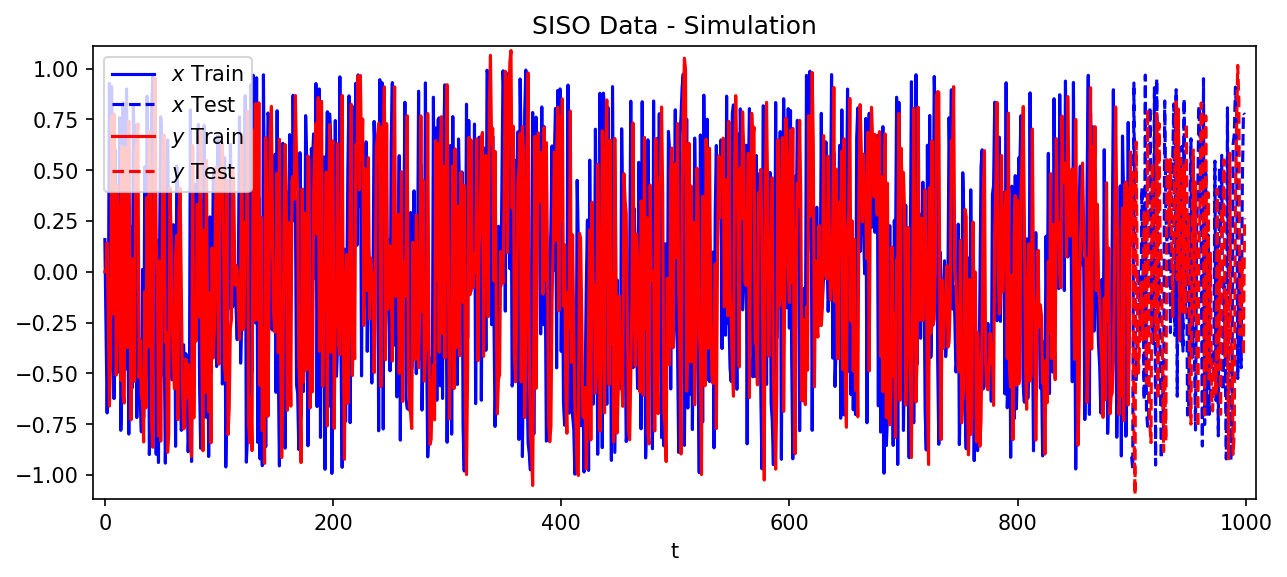

In [3]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('SISO Data - Simulation')
plt.plot(t_train, x_train, "b", label="$x$ Train")
plt.plot(t_test, x_valid, "b--", label="$x$ Test")
plt.plot(t_train, y_train, "r", label="$y$ Train")
plt.plot(t_test, y_valid, "r--", label="$y$ Test")
plt.margins(0.01, tight=True)
plt.xlabel("t")
plt.legend()
print(end='')

In [4]:
# FROLS: Forward Regression Orthogonal Least Squares algorithm
narmax_model = FROLS(
    order_selection=True,
    n_info_values=3,
    extended_least_squares=False,
    ylag=2, xlag=2,
    info_criteria='aic',
    estimator='least_squares',
    basis_function=Polynomial(degree=2)
)

narmax_model.fit(X=x_train, y=y_train)
r = pd.DataFrame(results(
    narmax_model.final_model, narmax_model.theta, narmax_model.err,
    narmax_model.n_terms, err_precision=8, dtype='sci'), columns=['Regressors', 'Parameters', 'ERR'])
print(r)

y_sim = narmax_model.predict(X=x_valid, y=y_valid[:2])

      Regressors  Parameters             ERR
0        x1(k-2)  9.0000E-01  9.56401106E-01
1         y(k-1)  1.9999E-01  4.02219192E-02
2  x1(k-1)y(k-1)  9.9991E-02  3.37693864E-03


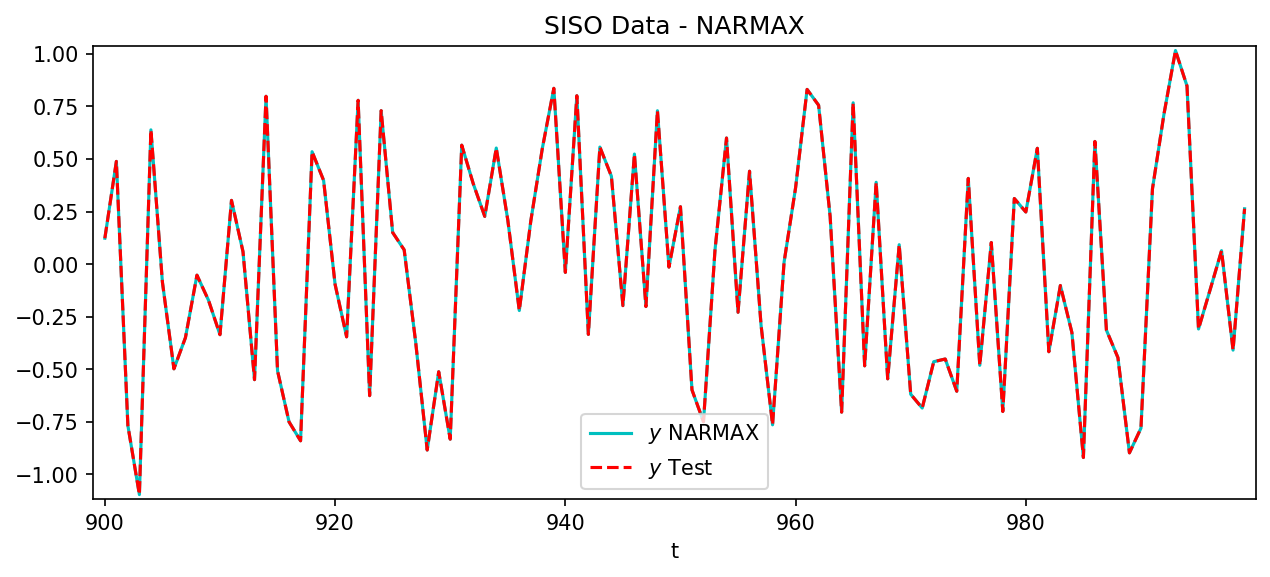

In [5]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('SISO Data - NARMAX')
plt.plot(t_test, y_sim, "c", label="$y$ NARMAX")
plt.plot(t_test, y_valid, "r--", label="$y$ Test")
plt.margins(0.01, tight=True)
plt.xlabel("t")
plt.legend()
print(end='')

In [6]:
# Define SINDy Model with control (SINDYc)
sindy_model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.05),
    feature_library=ps.PolynomialLibrary(degree=5),
    feature_names=['y', 'x_k-1', 'x_k-2'],
    discrete_time=True
)

# Fit and print resulting model
u_train = np.hstack((x_train[1:], x_train[:-1]))
sindy_model.fit(y_train[1:], u=u_train, quiet=True)
sindy_model.print()

# Simulate SINDy on the test data
first = np.hstack((x_valid[0], x_train[-1])) # First Input is needed to simulate y_valid[1]
u_test = np.hstack((x_valid[1:], x_valid[:-1]))
u_test = np.vstack((first, u_test)).reshape(-1, 1, u_train.shape[1])
y_sim = sindy_model.simulate(y_valid[0], t=len(y_valid), u=u_test)[:,0]

y[k+1] = 0.200 y[k] + 0.900 x_k-2[k] + 0.100 y[k] x_k-1[k]


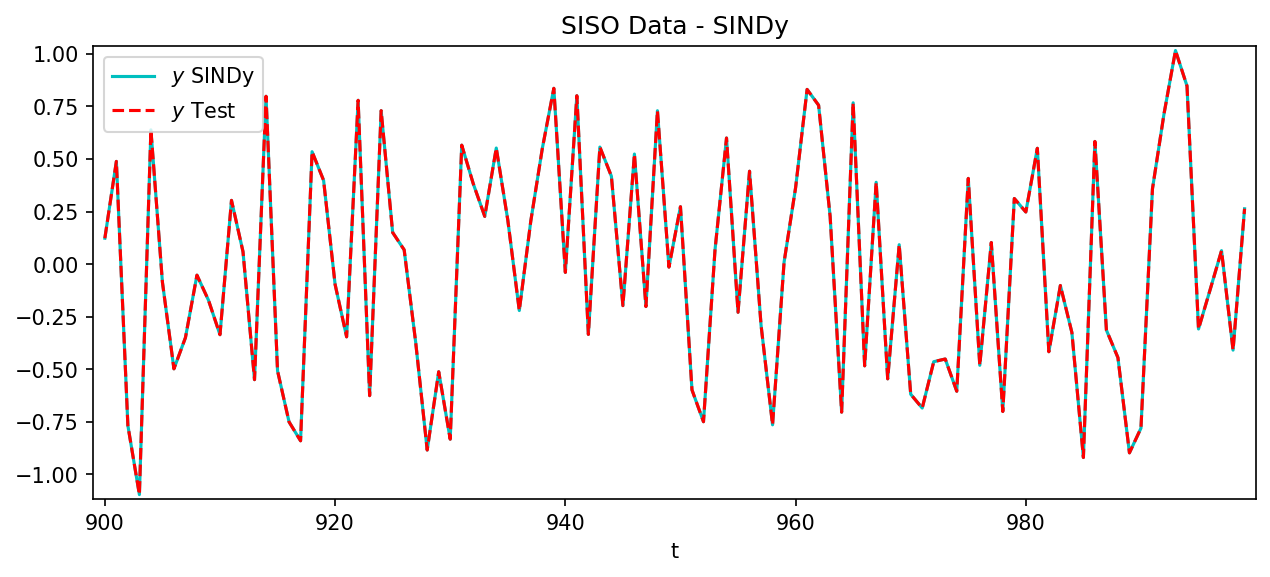

In [7]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('SISO Data - SINDy')
plt.plot(t_test, y_sim, "c", label="$y$ SINDy")
plt.plot(t_test, y_valid, "r--", label="$y$ Test")
plt.margins(0.01, tight=True)
plt.xlabel("t")
plt.legend()
print(end='')

$$\Large \text{Multiple Inputs Single Output}$$
$$\large y_k = 0.4y_{k-1}^2 + 0.1y_{k-1}x1_{k-1} + 0.6x2_{k-1} -0.3x1_{k-1}x2_{k-2} + e_{k}$$

In [8]:
# Generate 1000 Samples with White noise
# In this cases the MISO data is represented by an input x, a uniformly distributed
# random vector, and the scalar output y. The model attempts to identify the transfer
# function x -> y.
N = 1000
x_train, x_valid, y_train, y_valid = get_miso_data(n=N,
                                                   colored_noise=False,
                                                   sigma=0.001,
                                                   train_percentage=90)
t_train, t_test = train_test_split(list(range(N)), test_size=0.1, shuffle=False)

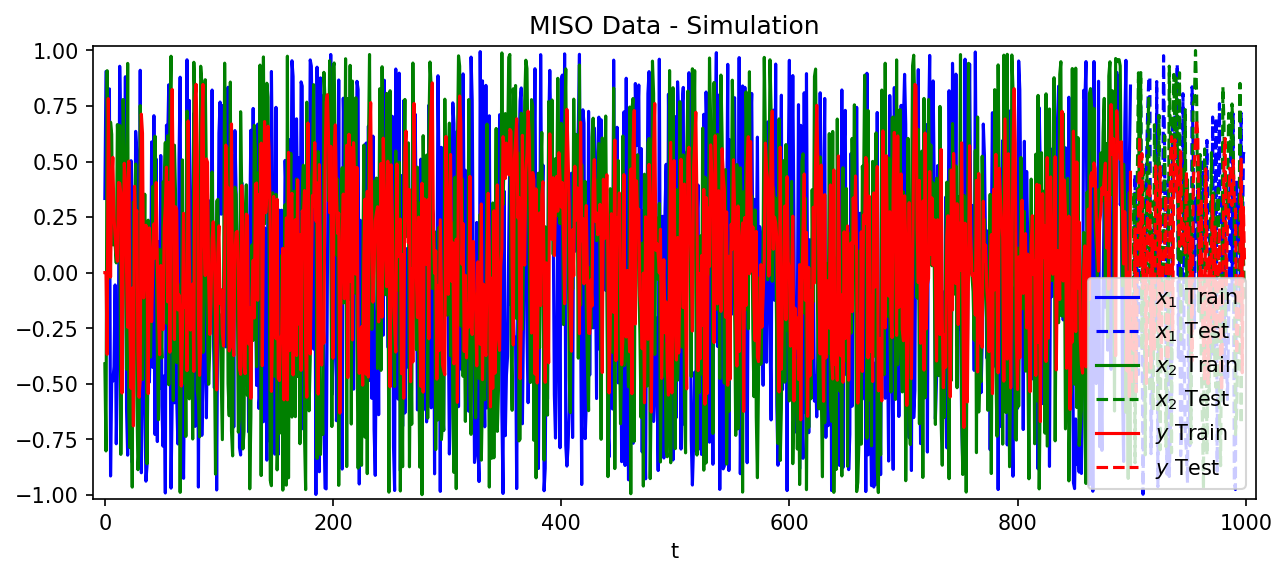

In [9]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('MISO Data - Simulation')
plt.plot(t_train, x_train[:,0], "b", label="$x_1$ Train")
plt.plot(t_test, x_valid[:,0], "b--", label="$x_1$ Test")
plt.plot(t_train, x_train[:,1], "g", label="$x_2$ Train")
plt.plot(t_test, x_valid[:,1], "g--", label="$x_2$ Test")
plt.plot(t_train, y_train, "r", label="$y$ Train")
plt.plot(t_test, y_valid, "r--", label="$y$ Test")
plt.margins(0.01, tight=True)
plt.xlabel("t")
plt.legend()
print(end='')

In [10]:
# FROLS: Forward Regression Orthogonal Least Squares algorithm
narmax_model = FROLS(
    order_selection=True,
    n_terms=4,
    extended_least_squares=False,
    ylag=2, xlag=[[1, 2], [1, 2]],
    info_criteria='aic',
    estimator='least_squares',
    basis_function=Polynomial(degree=2)
)

narmax_model.fit(X=x_train, y=y_train)
r = pd.DataFrame(results(
    narmax_model.final_model, narmax_model.theta, narmax_model.err,
    narmax_model.n_terms, err_precision=8, dtype='sci'), columns=['Regressors', 'Parameters', 'ERR'])
print(r)

y_sim = narmax_model.predict(X=x_valid, y=y_valid[:2])

       Regressors   Parameters             ERR
0         x2(k-1)   5.9995E-01  9.09954137E-01
1        y(k-1)^2   3.9986E-01  4.64055628E-02
2  x2(k-2)x1(k-1)  -3.0006E-01  4.33652503E-02
3   x1(k-1)y(k-1)   9.9825E-02  2.67554580E-04


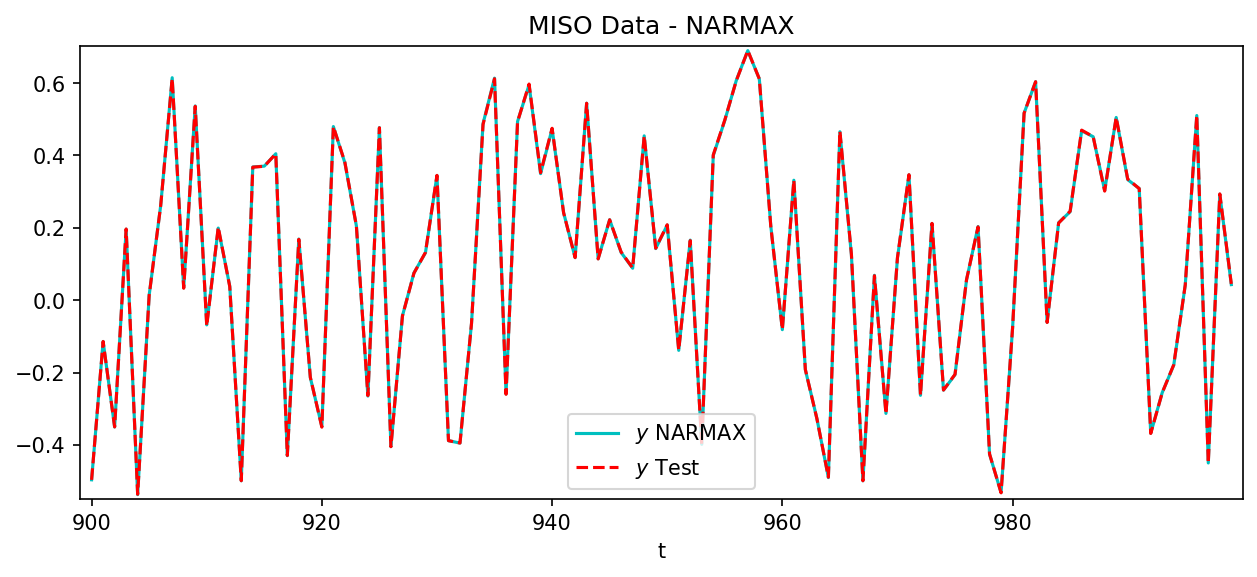

In [11]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('MISO Data - NARMAX')
plt.plot(t_test, y_sim, "c", label="$y$ NARMAX")
plt.plot(t_test, y_valid, "r--", label="$y$ Test")
plt.margins(0.01, tight=True)
plt.xlabel("t")
plt.legend()
print(end='')

In [12]:
# Define SINDy Model with control (SINDYc)
sindy_model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.05),
    feature_library=ps.PolynomialLibrary(degree=5),
    feature_names=['y', 'x1_k-1', 'x2_k-1', 'x1_k-2', 'x2_k-2'],
    discrete_time=True
)

# Fit and print resulting model
u_train = np.hstack((x_train[1:], x_train[:-1]))
sindy_model.fit(y_train[1:], u=u_train, quiet=True)
sindy_model.print()

# Simulate SINDy on the test data
first = np.hstack((x_valid[0], x_train[-1])) # First Input is needed to simulate y_valid[1]
u_test = np.hstack((x_valid[1:], x_valid[:-1]))
u_test = np.vstack((first, u_test)).reshape(-1, 1, u_train.shape[1])
y_sim = sindy_model.simulate(y_valid[0], t=len(y_valid), u=u_test)[:,0]

y[k+1] = 0.600 x2_k-1[k] + 0.400 y[k]^2 + 0.100 y[k] x1_k-1[k] + -0.300 x1_k-1[k] x2_k-2[k]


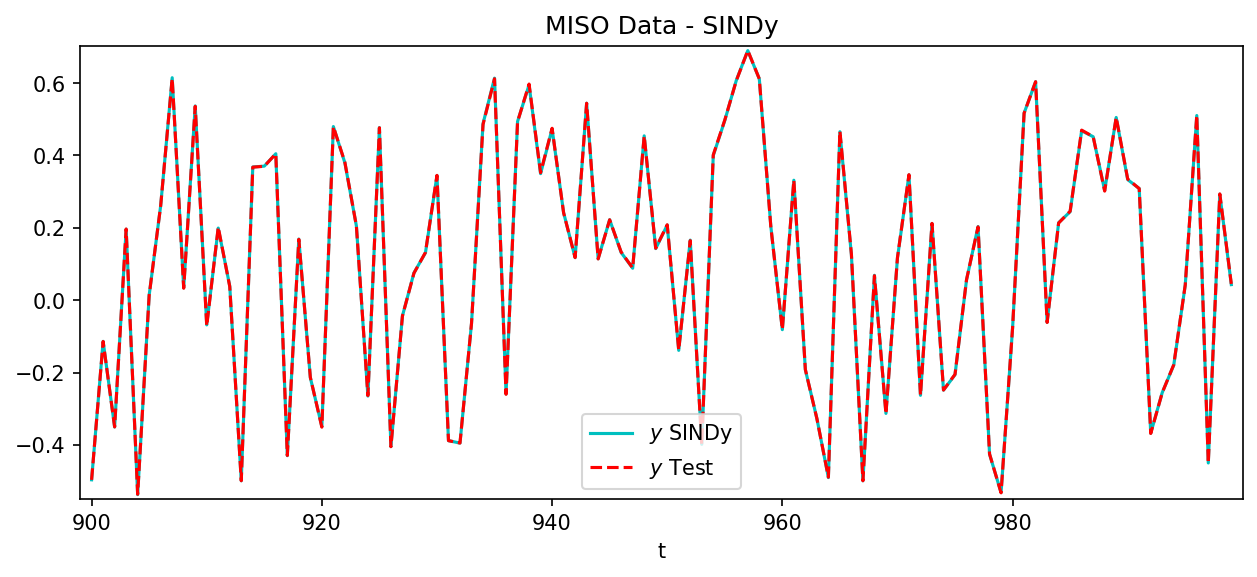

In [13]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('MISO Data - SINDy')
plt.plot(t_test, y_sim, "c", label="$y$ SINDy")
plt.plot(t_test, y_valid, "r--", label="$y$ Test")
plt.margins(0.01, tight=True)
plt.xlabel("t")
plt.legend()
print(end='')